In [1]:
import itertools
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, f1_score,accuracy_score, classification_report
from skimage import io, feature

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

In [ ]:
# Define the paths
train_dir = 'Wafermap/balanced'
test_dir = 'Wafermap/test'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 
test_datagen = ImageDataGenerator(rescale=1./255)

t_size = (26, 26)
b_size = 16

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=t_size,  # Resize images to 150x150
    batch_size=b_size,
    class_mode='categorical',
    subset='training'
)

# Load and preprocess the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=t_size,
    batch_size=b_size,
    class_mode='categorical',
    subset='validation'
)

# Load and preprocess the testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=t_size,
    batch_size=b_size,
    class_mode='categorical'
)

def load_data(generator):
    x_data = []
    y_data = []
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        x_data.append(x_batch)
        y_data.append(y_batch)
    return np.concatenate(x_data), np.concatenate(y_data)

x_train, y_train = load_data(train_generator)
x_val, y_val = load_data(validation_generator)
x_test, y_test = load_data(test_generator)

Found 2284 images belonging to 7 classes.
Found 564 images belonging to 7 classes.
Found 653 images belonging to 7 classes.


In [4]:
print(f"x_train shape: {x_train.shape}, number of samples: {x_train.shape[0]}")
print(f"x_val shape: {x_val.shape}, number of samples: {x_val.shape[0]}")
print(f"x_test shape: {x_test.shape}, number of samples: {x_test.shape[0]}")

print(f"y_train shape: {y_train.shape}, number of samples: {y_train.shape[0]}")
print(f"y_val shape: {y_val.shape}, number of samples: {y_val.shape[0]}")
print(f"y_test shape: {y_test.shape}, number of samples: {y_test.shape[0]}")

x_train shape: (2284, 26, 26, 3), number of samples: 2284
x_val shape: (564, 26, 26, 3), number of samples: 564
x_test shape: (653, 26, 26, 3), number of samples: 653
y_train shape: (2284, 7), number of samples: 2284
y_val shape: (564, 7), number of samples: 564
y_test shape: (653, 7), number of samples: 653


In [5]:
img_shape = x_train.shape[1:]

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', input_shape=(img_shape),
            activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax')) 

# learning rate
adam = Adam(learning_rate=0.0003)

model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,439 (1.84 MB)

 Trainable params: 482,439 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=13,
    callbacks=[early_stopping]
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3452 - loss: 1.6132 - val_accuracy: 0.6897 - val_loss: 0.8777
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7297 - loss: 0.7681 - val_accuracy: 0.7677 - val_loss: 0.5742
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8121 - loss: 0.5241 - val_accuracy: 0.7943 - val_loss: 0.4778
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8742 - loss: 0.3813 - val_accuracy: 0.8262 - val_loss: 0.4196
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8736 - loss: 0.3401 - val_accuracy: 0.8599 - val_loss: 0.3880
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8985 - loss: 0.3052 - val_accuracy: 0.8493 - val_loss: 0.3966
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8922 - loss: 0.2769 - val_accuracy: 0.8564 - val_loss: 0.3586
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9216 - loss: 0.2337 - val_accu

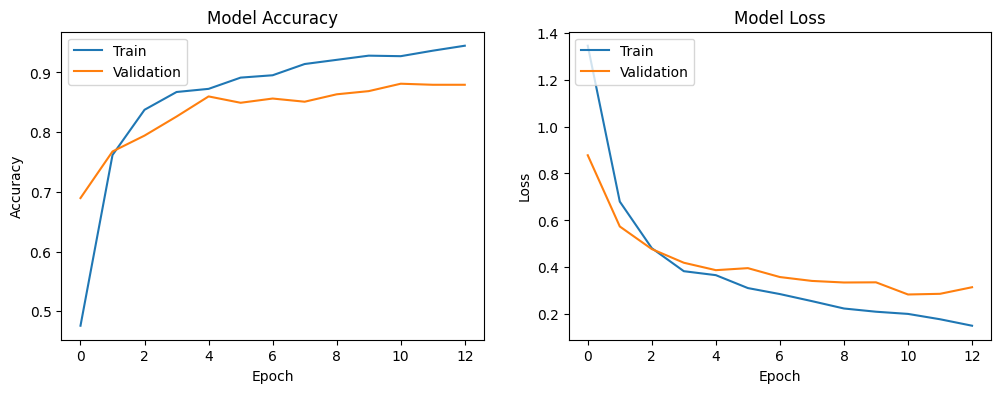

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


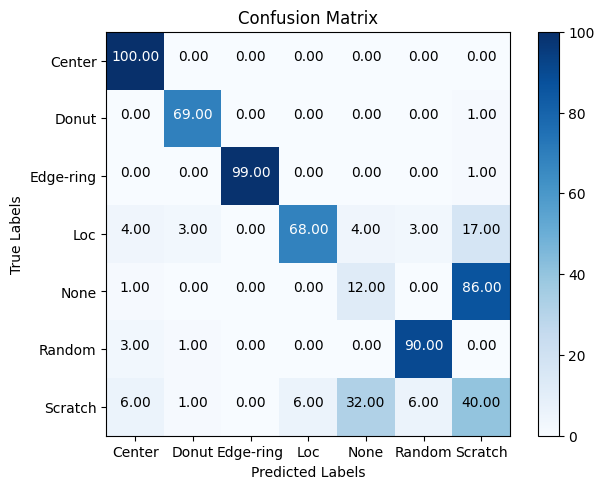

In [ ]:
# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=train_generator.class_indices.keys(), title='Confusion Matrix')
plt.show()


In [9]:
precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

mean_precision = np.mean(precision_per_class)
mean_recall = np.mean(recall_per_class)
mean_f1_score = np.mean(f1_score_per_class)

# Print results
for class_idx, prec, rec, f1 in zip(range(len(precision_per_class)), precision_per_class, recall_per_class, f1_score_per_class):
    print(f'Class {class_idx}: Precision={prec:.2f}, Recall={rec:.2f}, F1-score={f1:.2f}')

print(f'\nAverages (Micro): Precision={mean_precision:.2f}, Recall={mean_recall:.2f}, F1-score={mean_f1_score:.2f}')
print(f'Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.2f}')

Class 0: Precision=0.88, Recall=1.00, F1-score=0.93
Class 1: Precision=0.93, Recall=0.99, F1-score=0.96
Class 2: Precision=1.00, Recall=0.99, F1-score=0.99
Class 3: Precision=0.92, Recall=0.69, F1-score=0.79
Class 4: Precision=0.25, Recall=0.12, F1-score=0.16
Class 5: Precision=0.91, Recall=0.96, F1-score=0.93
Class 6: Precision=0.28, Recall=0.44, F1-score=0.34

Averages (Micro): Precision=0.74, Recall=0.74, F1-score=0.73
Accuracy: 0.73


class 4 "none" mistaken for class 6 "scratch" by a large margin, we should look at few samples from both classes

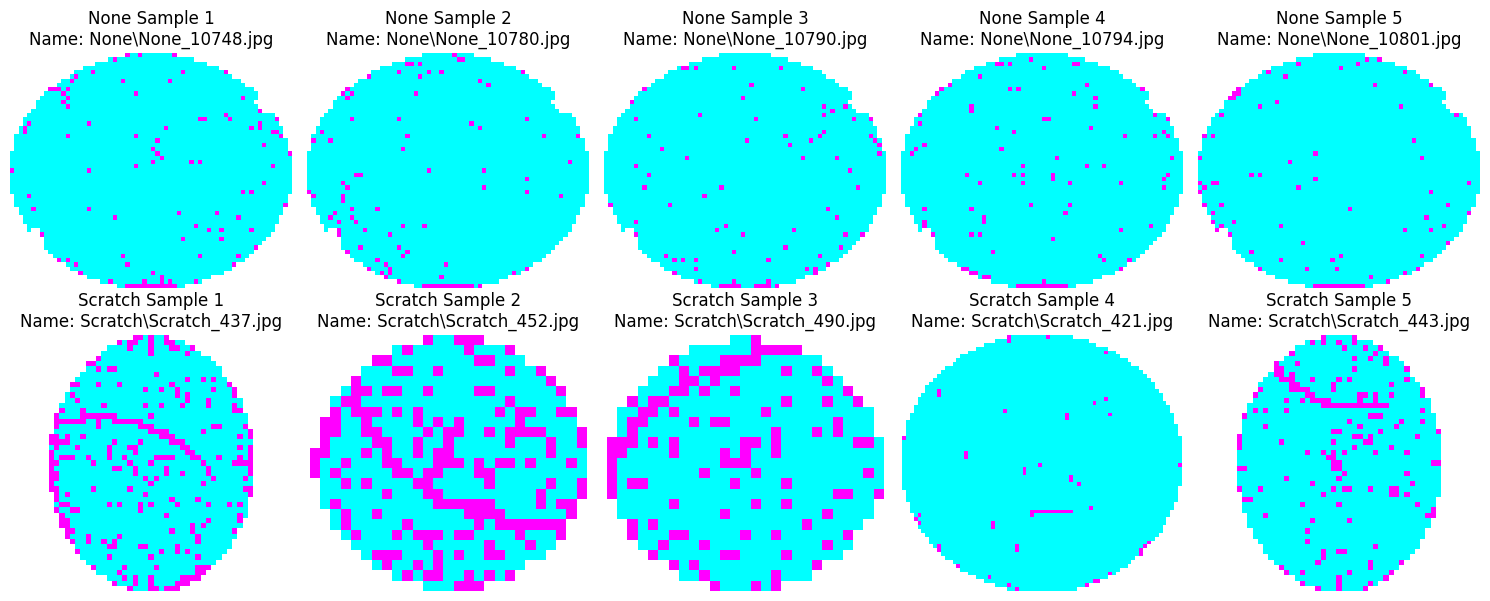

In [21]:
import random

# Get the class indices for "None" and "Scratch"
none_class_idx = test_generator.class_indices['None']
scratch_class_idx = test_generator.class_indices['Scratch']

# Get the filenames for the test samples
test_filenames = test_generator.filenames

# Filter filenames for "None" and "Scratch" classes
none_filenames = [f for f, label in zip(test_filenames, test_generator.labels) if label == none_class_idx]
scratch_filenames = [f for f, label in zip(test_filenames, test_generator.labels) if label == scratch_class_idx]

# Select 5 random samples from each class
random_none_samples = random.sample(none_filenames, 5)
random_scratch_samples = random.sample(scratch_filenames, 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (none_sample, scratch_sample) in enumerate(zip(random_none_samples, random_scratch_samples)):
    # Load and plot "None" samples
    none_img = mpimg.imread(os.path.join(test_dir, none_sample))
    axes[0, i].imshow(none_img)
    axes[0, i].set_title(f"None Sample {i+1}\nName: {none_sample}")
    axes[0, i].axis('off')
    
    # Load and plot "Scratch" samples
    scratch_img = mpimg.imread(os.path.join(test_dir, scratch_sample))
    axes[1, i].imshow(scratch_img)
    axes[1, i].set_title(f"Scratch Sample {i+1}\nName: {scratch_sample}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

now let's look at training data samples 

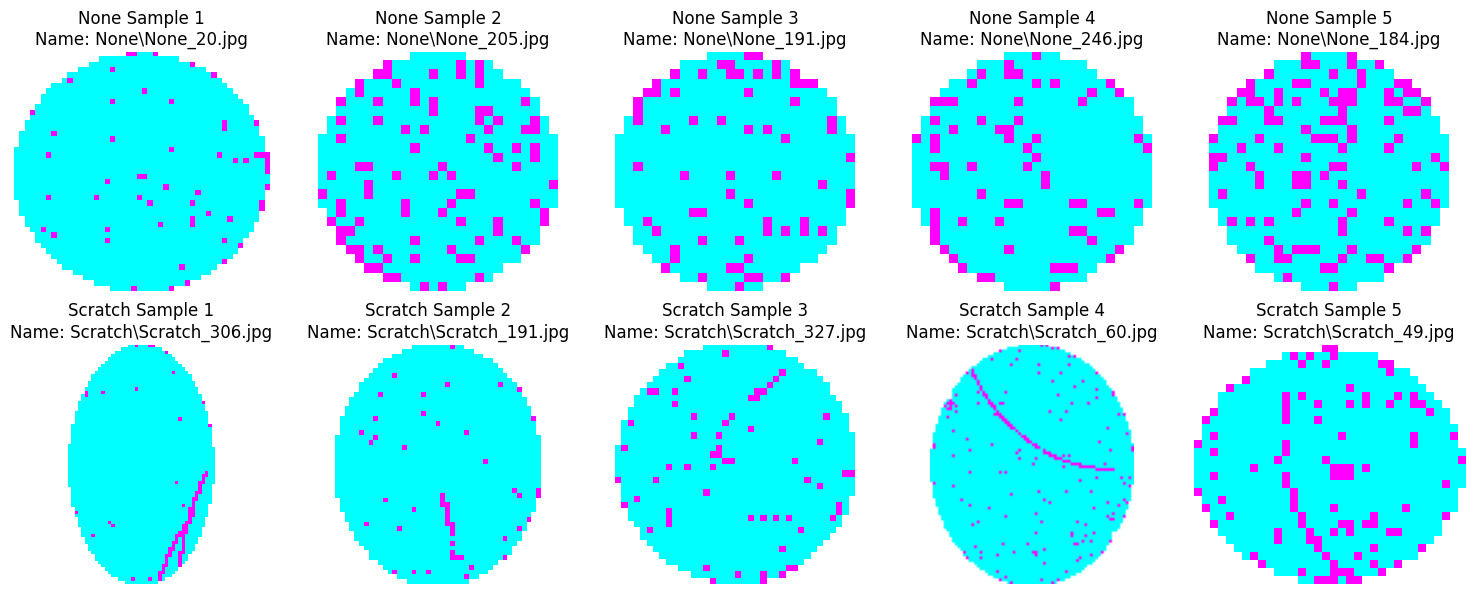

In [22]:
none_class_idx_train = train_generator.class_indices['None']
scratch_class_idx_train = train_generator.class_indices['Scratch']

train_filenames = train_generator.filenames

none_filenames_train = [f for f, label in zip(train_filenames, train_generator.labels) if label == none_class_idx_train]
scratch_filenames_train = [f for f, label in zip(train_filenames, train_generator.labels) if label == scratch_class_idx_train]

random_none_samples_train = random.sample(none_filenames_train, 5)
random_scratch_samples_train = random.sample(scratch_filenames_train, 5)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (none_sample_train, scratch_sample_train) in enumerate(zip(random_none_samples_train, random_scratch_samples_train)):
    none_img_train = mpimg.imread(os.path.join(train_dir, none_sample_train))
    axes[0, i].imshow(none_img_train)
    axes[0, i].set_title(f"None Sample {i+1}\nName: {none_sample_train}")
    axes[0, i].axis('off')
    
    scratch_img_train = mpimg.imread(os.path.join(train_dir, scratch_sample_train))
    axes[1, i].imshow(scratch_img_train)
    axes[1, i].set_title(f"Scratch Sample {i+1}\nName: {scratch_sample_train}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

The training and test data for the 'None' class are clearly different, with the test data showing more traits similar to the 'Scratch' class. This likely resulted from my manual interference with the test folder while experimenting with the initially imbalanced dataset. There are far more images in the 'None' class compared to the other classes, and some of the images I selected for testing (sorted at the end of the folder) resemble the 'Scratch' class more closely. I'll now replace the test data for the 'None' class with more suitable and closer-matching neverseen data.

Found 654 images belonging to 7 classes.
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


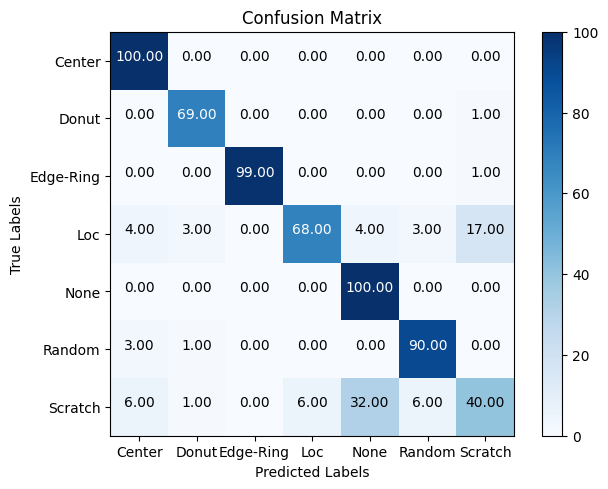

Class 0: Precision=0.88, Recall=1.00, F1-score=0.94
Class 1: Precision=0.93, Recall=0.99, F1-score=0.96
Class 2: Precision=1.00, Recall=0.99, F1-score=0.99
Class 3: Precision=0.92, Recall=0.69, F1-score=0.79
Class 4: Precision=0.74, Recall=1.00, F1-score=0.85
Class 5: Precision=0.91, Recall=0.96, F1-score=0.93
Class 6: Precision=0.68, Recall=0.44, F1-score=0.53

Averages (Micro): Precision=0.87, Recall=0.87, F1-score=0.86
Accuracy: 0.87


In [28]:
# Reload and preprocess the testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=t_size,
    batch_size=b_size,
    class_mode='categorical'
)

x_test, y_test = load_data(test_generator)

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=test_generator.class_indices.keys(), title='Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1-score
precision_per_class = np.diag(cm) / np.sum(cm, axis=0)
recall_per_class = np.diag(cm) / np.sum(cm, axis=1)
f1_score_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

mean_precision = np.mean(precision_per_class)
mean_recall = np.mean(recall_per_class)
mean_f1_score = np.mean(f1_score_per_class)

# Print results
for class_idx, prec, rec, f1 in zip(range(len(precision_per_class)), precision_per_class, recall_per_class, f1_score_per_class):
    print(f'Class {class_idx}: Precision={prec:.2f}, Recall={rec:.2f}, F1-score={f1:.2f}')

print(f'\nAverages (Micro): Precision={mean_precision:.2f}, Recall={mean_recall:.2f}, F1-score={mean_f1_score:.2f}')
print(f'Accuracy: {accuracy_score(y_true_classes, y_pred_classes):.2f}')

As expected, the model has far better performing metrics now, though still scratch class predictions torn between itself and None class. This is likely due to similarity in training data between two classes, as we have seen from the samples above. For now I will proceed with this version.

In [31]:
from tensorflow.keras.models import Model

# Freeze the layers
for layer in model.layers:
    layer.trainable = False

# Create a feature extraction model
feature_extractor = Model(model.inputs, model.layers[-4].output)

feature_extractor.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 26, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,472 (724.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 185,472 (724.50 KB)

In [ ]:
# Extract features from the training, validation, and test sets
train_features = feature_extractor.predict(x_train)
#val_features = feature_extractor.predict(x_val)
test_features = feature_extractor.predict(x_test)

print(f"Train features shape: {train_features.shape}")
#print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train features shape: (2284, 1152)
Test features shape: (654, 1152)


SVM Classifier Accuracy: 0.88
              precision    recall  f1-score   support

      Center       0.92      0.98      0.95       100
       Donut       0.90      1.00      0.95        70
   Edge-Ring       0.98      0.99      0.99       100
         Loc       0.84      0.67      0.74        99
        None       0.85      0.94      0.89       100
      Random       0.92      0.98      0.95        94
     Scratch       0.71      0.62      0.66        91

    accuracy                           0.88       654
   macro avg       0.87      0.88      0.87       654
weighted avg       0.87      0.88      0.87       654



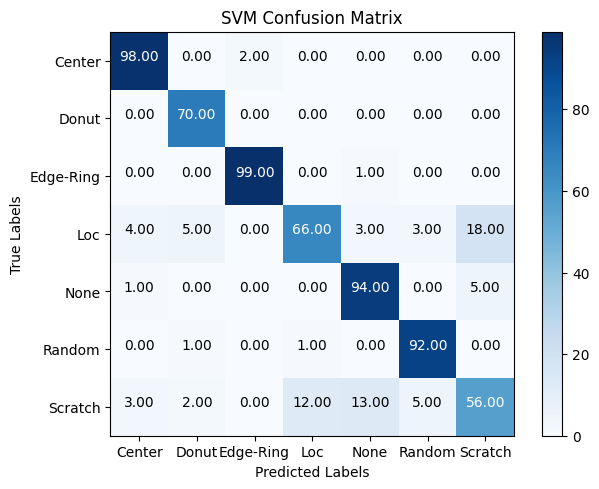

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_classifier = SVC(kernel='linear', probability=True)

# Train the SVM classifier on the combined features and labels
svm_classifier.fit(train_features, np.argmax(y_train, axis=1))

# Predict on the test features
y_pred_svm = svm_classifier.predict(test_features)

# Calculate accuracy
accuracy_svm = accuracy_score(np.argmax(y_test, axis=1), y_pred_svm)
print(f"SVM Classifier Accuracy: {accuracy_svm:.2f}")

# classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_svm, target_names=test_generator.class_indices.keys()))

# confusion matrix
cm_svm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_svm)
plot_confusion_matrix(cm_svm, classes=test_generator.class_indices.keys(), title='SVM Confusion Matrix')

Random Forest Classifier Accuracy: 0.87
              precision    recall  f1-score   support

      Center       0.91      1.00      0.95       100
       Donut       0.89      1.00      0.94        70
   Edge-Ring       1.00      0.96      0.98       100
         Loc       0.86      0.83      0.85        99
        None       0.73      1.00      0.84       100
      Random       0.92      0.97      0.94        94
     Scratch       0.87      0.36      0.51        91

    accuracy                           0.87       654
   macro avg       0.88      0.87      0.86       654
weighted avg       0.88      0.87      0.86       654



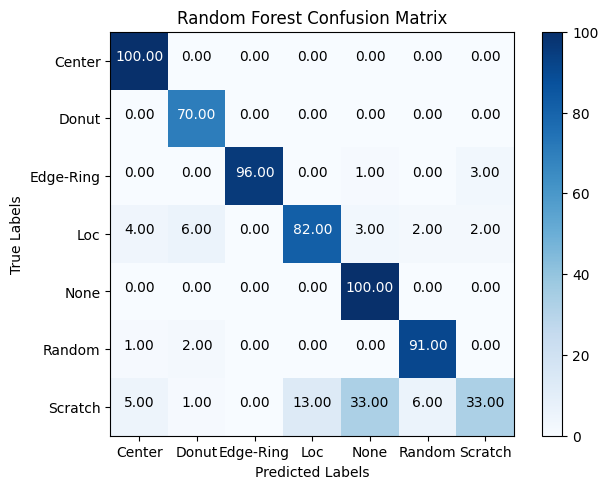

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier on the training features and labels
rf_classifier.fit(train_features, np.argmax(y_train, axis=1))

# Predict on the test features
y_pred_rf = rf_classifier.predict(test_features)

# Calculate accuracy
accuracy_rf = accuracy_score(np.argmax(y_test, axis=1), y_pred_rf)
print(f"Random Forest Classifier Accuracy: {accuracy_rf:.2f}")

# Classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_rf, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm_rf = confusion_matrix(np.argmax(y_test, axis=1), y_pred_rf)
plot_confusion_matrix(cm_rf, classes=test_generator.class_indices.keys(), title='Random Forest Confusion Matrix')

Logistic Regression Classifier Accuracy: 0.89
              precision    recall  f1-score   support

      Center       0.93      1.00      0.97       100
       Donut       0.90      1.00      0.95        70
   Edge-Ring       1.00      0.98      0.99       100
         Loc       0.88      0.74      0.80        99
        None       0.84      0.95      0.89       100
      Random       0.92      0.98      0.95        94
     Scratch       0.73      0.60      0.66        91

    accuracy                           0.89       654
   macro avg       0.89      0.89      0.89       654
weighted avg       0.89      0.89      0.89       654



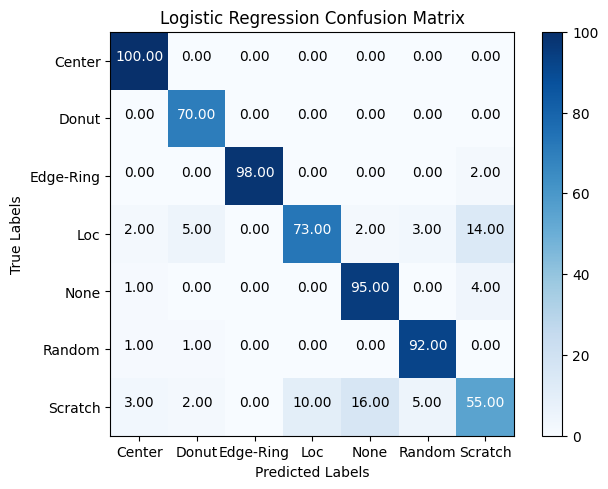

In [48]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression classifier on the training features and labels
logistic_regression_classifier.fit(train_features, np.argmax(y_train, axis=1))

# Predict on the test features
y_pred_lr = logistic_regression_classifier.predict(test_features)

# Calculate accuracy
accuracy_lr = accuracy_score(np.argmax(y_test, axis=1), y_pred_lr)
print(f"Logistic Regression Classifier Accuracy: {accuracy_lr:.2f}")

# Classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred_lr, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm_lr = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lr)
plot_confusion_matrix(cm_lr, classes=test_generator.class_indices.keys(), title='Logistic Regression Confusion Matrix')

Now let's compare all of them with each other

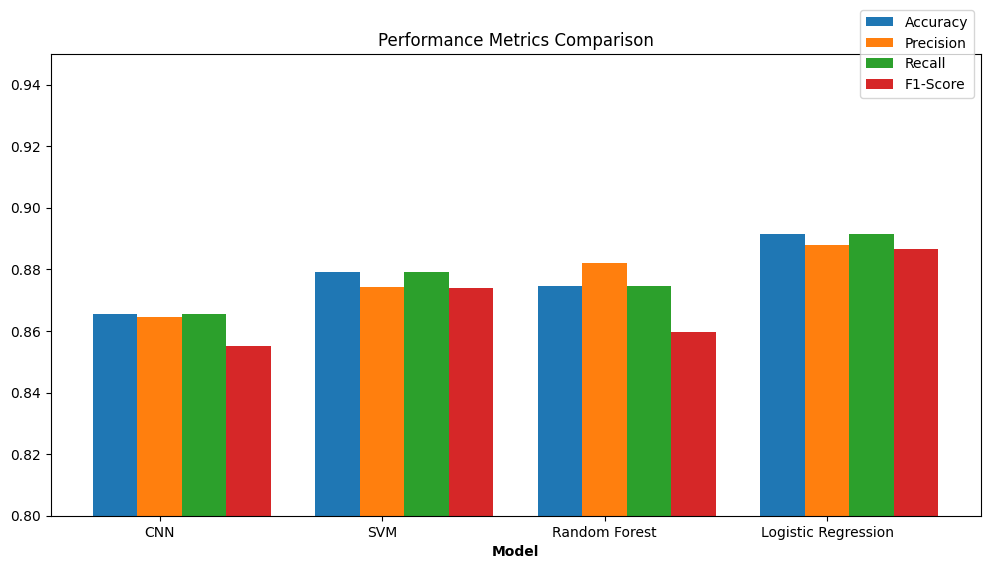

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the performance of the CNN model
cnn_accuracy = accuracy_score(y_true_classes, y_pred_classes)
cnn_precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
cnn_recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
cnn_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Evaluate the performance of the SVM model
svm_accuracy = accuracy_score(y_true_classes, y_pred_svm)
svm_precision = precision_score(y_true_classes, y_pred_svm, average='weighted')
svm_recall = recall_score(y_true_classes, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_true_classes, y_pred_svm, average='weighted')

# Evaluate the performance of the Random Forest model
rf_accuracy = accuracy_score(y_true_classes, y_pred_rf)
rf_precision = precision_score(y_true_classes, y_pred_rf, average='weighted')
rf_recall = recall_score(y_true_classes, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_true_classes, y_pred_rf, average='weighted')

# Evaluate the performance of the Logistic Regression model
lr_accuracy = accuracy_score(y_true_classes, y_pred_lr)
lr_precision = precision_score(y_true_classes, y_pred_lr, average='weighted')
lr_recall = recall_score(y_true_classes, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_true_classes, y_pred_lr, average='weighted')

# Prepare data for plotting
models = ['CNN', 'SVM', 'Random Forest', 'Logistic Regression']
accuracies = [cnn_accuracy, svm_accuracy, rf_accuracy, lr_accuracy]
precisions = [cnn_precision, svm_precision, rf_precision, lr_precision]
recalls = [cnn_recall, svm_recall, rf_recall, lr_recall]
f1_scores = [cnn_f1, svm_f1, rf_f1, lr_f1]

barWidth = 0.2
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(12, 6))

plt.bar(r1, accuracies, width=barWidth, label='Accuracy')
plt.bar(r2, precisions, width=barWidth, label='Precision')
plt.bar(r3, recalls, width=barWidth, label='Recall')
plt.bar(r4, f1_scores, width=barWidth, label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracies))], models)
plt.ylim(0.8, 0.95)
plt.title('Performance Metrics Comparison')
plt.legend(loc='center right', bbox_to_anchor=(1, 1))
plt.show()

While each classifier has been successful overall, the logistic regression model built with features extracted from convolutional layers has outperformed the rest.